# Setting

In [1]:
import os
import glob
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import copy, math

import torch.nn.functional as F
from torch.nn.modules.utils import _pair
from torch.nn.parameter import Parameter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix


from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch.utils.data import random_split

import torchvision.transforms as T

from models.shared_perceiver import crop, patchify, get_patch_coords, ImageDataset, PerceiverBlock, Perceiver
import models.layers as nl
import utils.manager as Manager


In [2]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정

def seed_worker(worker_id): #데이터로더 난수고정
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(42)
g = torch.Generator()
g.manual_seed(42)
NUM_WORKERS = 4 # 서브프로세스관리자 수. 난수생성과 관련있습니다. 일단은 4로 고정합니다.


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Functions

In [4]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return total_loss / len(dataloader), correct / total

In [5]:
def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(dataloader), correct / total

In [6]:
# def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs, device, scheduler=None):
#     best_model = None 
#     best_val_score = 0
#     model.train()
#     train_losses = []
#     val_accuracies = []
#     start = time.perf_counter()
    
#     for epoch in range(epochs):
#         total_loss = 0.0
#         for images, labels in train_loader:
#             # GPU로 옮기기
#             images = images.to(device)
#             labels = labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#         avg_loss = total_loss / len(train_loader)
#         train_losses.append(avg_loss)

#         accuracy = evaluate_model(model, valid_loader, device=device, log_results=False)
#         val_accuracies.append(accuracy)

#         # Scheduler step 추가
#         if scheduler:
#             scheduler.step()

#         print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {accuracy:.2f}%")
#         if accuracy > best_val_score:
#             best_val_score = accuracy
#             best_model_state = model.state_dict()  # 모델 상태 저장
#             best_model = copy.deepcopy(model) 
#             print(f"New best model found at epoch {epoch+1} with accuracy: {best_val_score:.2f}%")

#     end = time.perf_counter()
#     hour = (end-start) // 3600
#     min = ((end-start) % 3600) // 60
#     sec = int((end-start) % 60)
#     print(f"Total Train time: {hour}h {min}m {sec}s")

#     return train_losses, val_accuracies, best_model

# def evaluate_model(model, data_loader, device, log_results=True):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         start = time.perf_counter()
#         for images, labels in data_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#         end = time.perf_counter()
#         hour = (end-start) // 3600
#         min = ((end-start) % 3600) // 60
#         sec = (end-start) % 60
#         print(f"Elapsed time on CPU: {hour}h {min}m {sec}s")

#     accuracy = 100.0 * correct / total
#     if log_results:
#         print(f"Test Accuracy: {accuracy:.2f}%")
#     return accuracy


# Load Model 

In [7]:
data_dir = '/home/youlee/n24news/n24news/image'
CROP_SIZE = 16
PATCH_SIZE = 16
BATCH_SIZE = 32

EPOCHS = 40
K_FOLDS = 5
GROUP_CLASS = 3
LR = 5e-5

results = []

In [8]:
#random.shuffle(target_classes)
target_classes = [ # 임의로 순서지정
    "Opinion", "Art & Design", "Television",
    "Music", "Travel", "Real Estate",
    "Books", "Theater", "Health",
    "Sports", "Science", "Food",
    "Fashion & Style", "Movies", "Technology",
    "Dance", "Media", "Style"
]
target_classes

['Opinion',
 'Art & Design',
 'Television',
 'Music',
 'Travel',
 'Real Estate',
 'Books',
 'Theater',
 'Health',
 'Sports',
 'Science',
 'Food',
 'Fashion & Style',
 'Movies',
 'Technology',
 'Dance',
 'Media',
 'Style']

In [9]:
model_path = '/home/Minju/Perceiver/shared_layer_model'
loader_path = '/home/Minju/Perceiver/shared_layer_loader'

# Train Loop 

In [10]:
all_learning_curves = []
best_models = {} 

In [11]:
def train_kfold(task_id, dataset, num_classes, device, output_path, loader_path):
    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    best_model = None
    best_test_acc = 0.0
    best_subset = None

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\nFold {fold}/{K_FOLDS} 진행 중...")
        
        dataset_history = []
        dataset2num_classes = {}
        masks = {}
        shared_layer_info = {}
        
        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)
        
        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)
        
        model = Perceiver(
            dataset_history = dataset_history,
            dataset2num_classes=dataset2num_classes,
            network_width_multiplier=1,
            shared_layer_info=shared_layer_info,
            input_dim=(PATCH_SIZE**2) * 3 + 2,
            latent_dim=64,
            latent_size=64,
            num_classes=num_classes,
            num_blocks=4,
            self_attn_layers_per_block=1
        ).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=LR)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        
        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            scheduler.step()
            
            print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
            
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_model = copy.deepcopy(model)
                best_subset = test_subset
        
        # Evaluate final model on test set
        y_true, y_pred = [], []
        best_model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = best_model(images)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        
        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        
        results.append({
            "Fold": fold,
            "Test Accuracy": best_test_acc,
            "Confusion Matrix": cm,
            "Classification Report": report
        })
        
        all_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })
        
        # Plot Learning Curve
        plt.figure()
        plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
        plt.plot(range(1, EPOCHS + 1), test_losses, label="Test Loss")
        plt.title(f"Fold {fold} Learning Curve (Loss)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.plot(range(1, EPOCHS + 1), train_accuracies, label="Train Accuracy")
        plt.plot(range(1, EPOCHS + 1), test_accuracies, label="Test Accuracy")
        plt.title(f"Fold {fold} Learning Curve (Accuracy)")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
        
        # Plot Confusion Matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Fold {fold} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
    

    # Save best model
    # torch.save(best_model, f"{output_path}/image_model_{task_id}_fold{fold}.pkl")       # best model 저장.
    Manager.save_checkpoint(best_model, optimizer, epoch_idx=EPOCHS, save_folder=output_path, 
                            shared_layer_info=shared_layer_info, dataset='image', idx=task_id)
    
    # Save DataLoader
    with open(f"{loader_path}/image_val_loader_{task_id}_fold{fold}.pkl", "wb") as f:   # best model 당시의 test loader 저장.
        pickle.dump(best_subset, f)

    print("\n=== K-Fold 결과 요약 ===")
    for result in results:
        print(f"Fold {result['Fold']} - Test Accuracy: {result['Test Accuracy']:.4f}")
        print(pd.DataFrame(result["Classification Report"]).transpose())


실험 1 시작
Selected Feature: ['Opinion', 'Art & Design', 'Television']
Unique numeric labels: [0 1 2]
Number of unique numeric labels: 3
Label distribution (index: count): Counter({np.int64(1): 2437, np.int64(0): 2431, np.int64(2): 2419})

Fold 1/5 진행 중...
Epoch 1/40 - Train Loss: 1.0637, Train Acc: 0.4119, Test Acc: 0.4561
Epoch 2/40 - Train Loss: 1.0502, Train Acc: 0.4335, Test Acc: 0.4588
Epoch 3/40 - Train Loss: 1.0488, Train Acc: 0.4234, Test Acc: 0.4479
Epoch 4/40 - Train Loss: 1.0473, Train Acc: 0.4423, Test Acc: 0.4630
Epoch 5/40 - Train Loss: 1.0470, Train Acc: 0.4378, Test Acc: 0.4636
Epoch 6/40 - Train Loss: 1.0450, Train Acc: 0.4409, Test Acc: 0.4650
Epoch 7/40 - Train Loss: 1.0442, Train Acc: 0.4411, Test Acc: 0.4602
Epoch 8/40 - Train Loss: 1.0441, Train Acc: 0.4442, Test Acc: 0.4684
Epoch 9/40 - Train Loss: 1.0447, Train Acc: 0.4454, Test Acc: 0.4623
Epoch 10/40 - Train Loss: 1.0440, Train Acc: 0.4452, Test Acc: 0.4678
Epoch 11/40 - Train Loss: 1.0415, Train Acc: 0.4455, Te

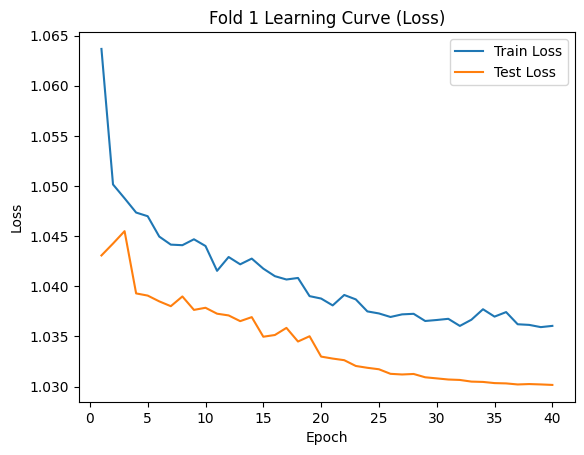

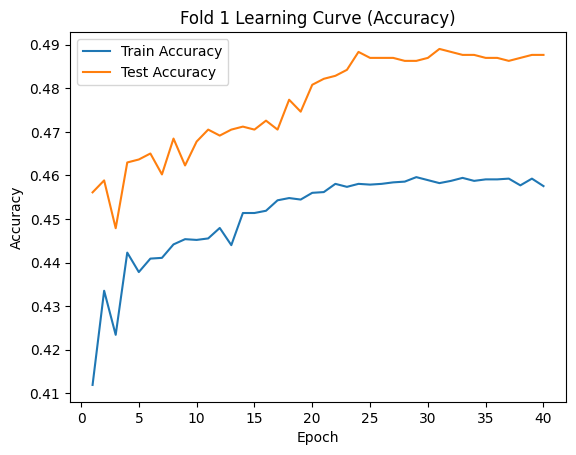

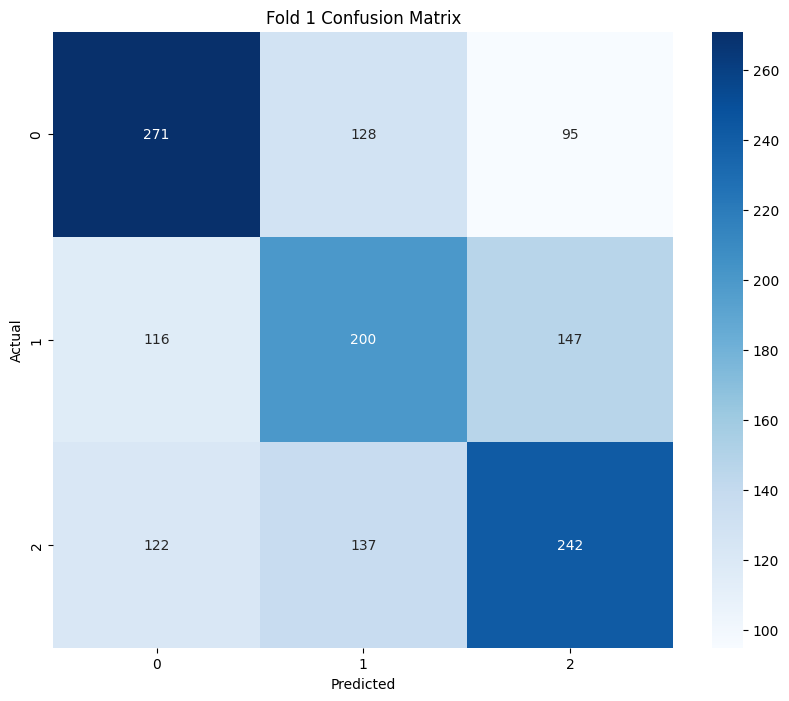


Fold 2/5 진행 중...
Epoch 1/40 - Train Loss: 1.0664, Train Acc: 0.4054, Test Acc: 0.4431
Epoch 2/40 - Train Loss: 1.0517, Train Acc: 0.4359, Test Acc: 0.4390
Epoch 3/40 - Train Loss: 1.0473, Train Acc: 0.4397, Test Acc: 0.4444
Epoch 4/40 - Train Loss: 1.0468, Train Acc: 0.4452, Test Acc: 0.4554
Epoch 5/40 - Train Loss: 1.0435, Train Acc: 0.4438, Test Acc: 0.4479
Epoch 6/40 - Train Loss: 1.0414, Train Acc: 0.4524, Test Acc: 0.4520
Epoch 7/40 - Train Loss: 1.0394, Train Acc: 0.4563, Test Acc: 0.4547
Epoch 8/40 - Train Loss: 1.0411, Train Acc: 0.4575, Test Acc: 0.4657
Epoch 9/40 - Train Loss: 1.0379, Train Acc: 0.4565, Test Acc: 0.4595
Epoch 10/40 - Train Loss: 1.0373, Train Acc: 0.4641, Test Acc: 0.4671
Epoch 11/40 - Train Loss: 1.0354, Train Acc: 0.4639, Test Acc: 0.4733
Epoch 12/40 - Train Loss: 1.0352, Train Acc: 0.4646, Test Acc: 0.4595
Epoch 13/40 - Train Loss: 1.0348, Train Acc: 0.4682, Test Acc: 0.4698
Epoch 14/40 - Train Loss: 1.0325, Train Acc: 0.4697, Test Acc: 0.4671
Epoch 15/40

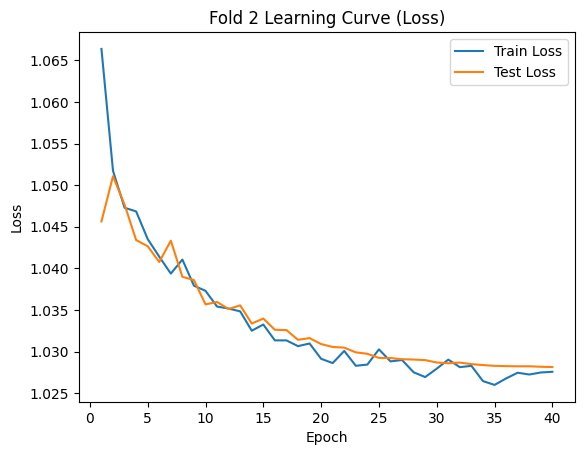

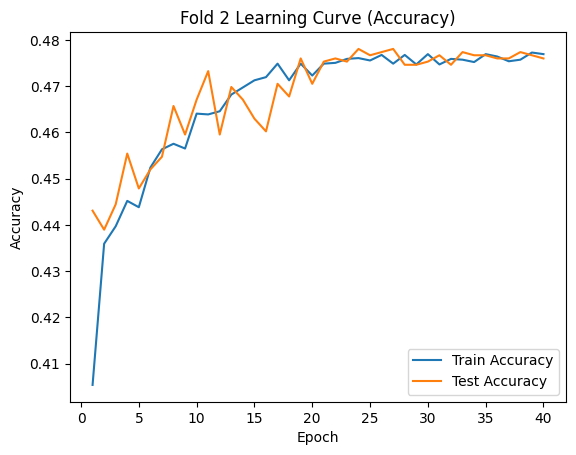

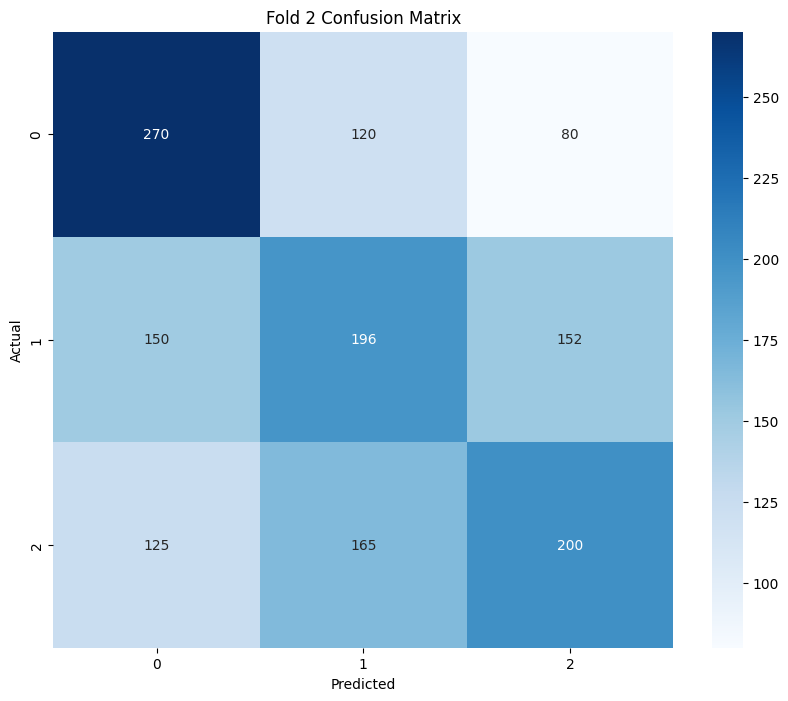


Fold 3/5 진행 중...
Epoch 1/40 - Train Loss: 1.0678, Train Acc: 0.4063, Test Acc: 0.4283
Epoch 2/40 - Train Loss: 1.0523, Train Acc: 0.4429, Test Acc: 0.4290
Epoch 3/40 - Train Loss: 1.0507, Train Acc: 0.4420, Test Acc: 0.4296
Epoch 4/40 - Train Loss: 1.0473, Train Acc: 0.4525, Test Acc: 0.4379
Epoch 5/40 - Train Loss: 1.0461, Train Acc: 0.4511, Test Acc: 0.4399
Epoch 6/40 - Train Loss: 1.0437, Train Acc: 0.4569, Test Acc: 0.4420
Epoch 7/40 - Train Loss: 1.0419, Train Acc: 0.4592, Test Acc: 0.4475
Epoch 8/40 - Train Loss: 1.0407, Train Acc: 0.4642, Test Acc: 0.4509
Epoch 9/40 - Train Loss: 1.0387, Train Acc: 0.4628, Test Acc: 0.4605
Epoch 10/40 - Train Loss: 1.0374, Train Acc: 0.4611, Test Acc: 0.4509
Epoch 11/40 - Train Loss: 1.0377, Train Acc: 0.4708, Test Acc: 0.4647
Epoch 12/40 - Train Loss: 1.0350, Train Acc: 0.4708, Test Acc: 0.4612
Epoch 13/40 - Train Loss: 1.0346, Train Acc: 0.4659, Test Acc: 0.4722
Epoch 14/40 - Train Loss: 1.0326, Train Acc: 0.4734, Test Acc: 0.4681
Epoch 15/40

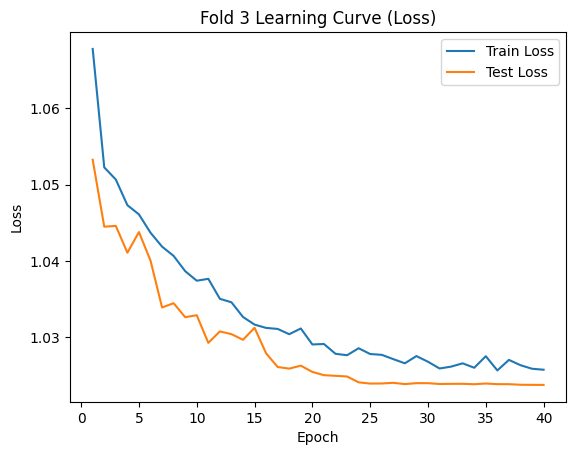

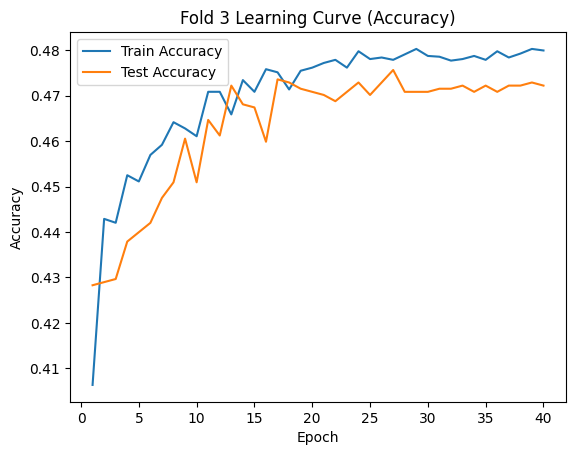

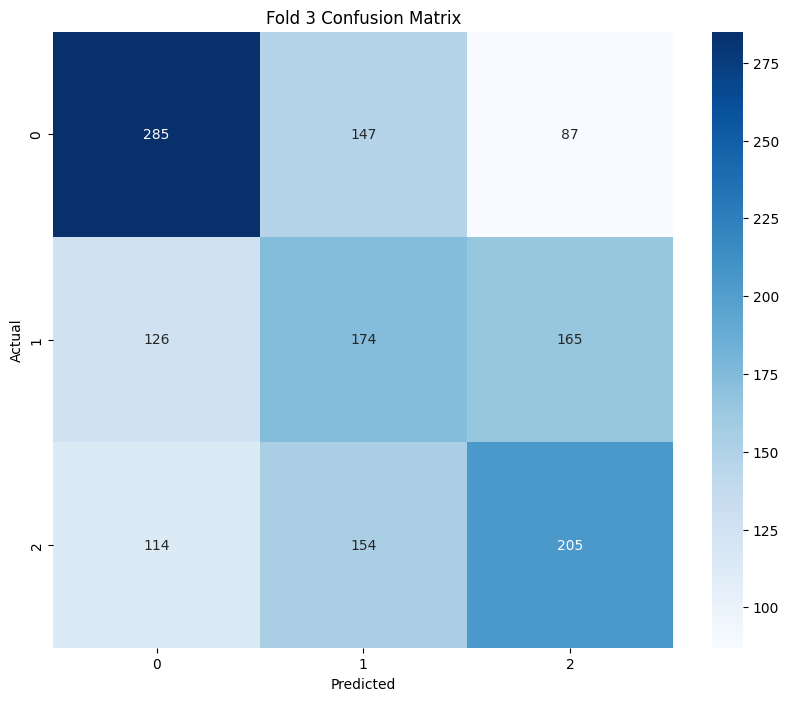


Fold 4/5 진행 중...
Epoch 1/40 - Train Loss: 1.0678, Train Acc: 0.4156, Test Acc: 0.4194
Epoch 2/40 - Train Loss: 1.0495, Train Acc: 0.4403, Test Acc: 0.4132
Epoch 3/40 - Train Loss: 1.0454, Train Acc: 0.4455, Test Acc: 0.4255
Epoch 4/40 - Train Loss: 1.0450, Train Acc: 0.4540, Test Acc: 0.4255
Epoch 5/40 - Train Loss: 1.0428, Train Acc: 0.4561, Test Acc: 0.4454
Epoch 6/40 - Train Loss: 1.0411, Train Acc: 0.4530, Test Acc: 0.4413
Epoch 7/40 - Train Loss: 1.0408, Train Acc: 0.4583, Test Acc: 0.4351
Epoch 8/40 - Train Loss: 1.0405, Train Acc: 0.4628, Test Acc: 0.4420
Epoch 9/40 - Train Loss: 1.0396, Train Acc: 0.4593, Test Acc: 0.4468
Epoch 10/40 - Train Loss: 1.0383, Train Acc: 0.4599, Test Acc: 0.4475
Epoch 11/40 - Train Loss: 1.0391, Train Acc: 0.4619, Test Acc: 0.4454
Epoch 12/40 - Train Loss: 1.0378, Train Acc: 0.4624, Test Acc: 0.4447
Epoch 13/40 - Train Loss: 1.0365, Train Acc: 0.4669, Test Acc: 0.4447
Epoch 14/40 - Train Loss: 1.0361, Train Acc: 0.4717, Test Acc: 0.4420
Epoch 15/40

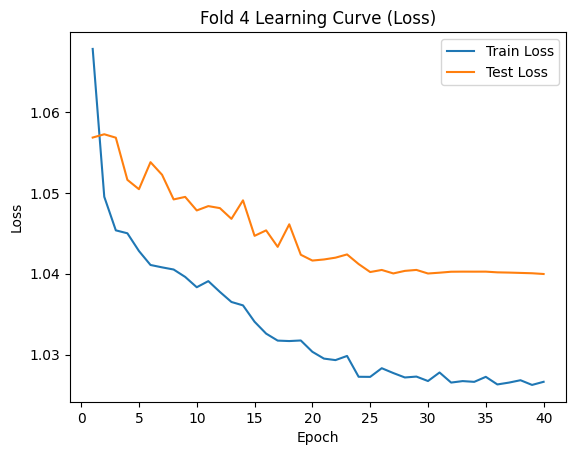

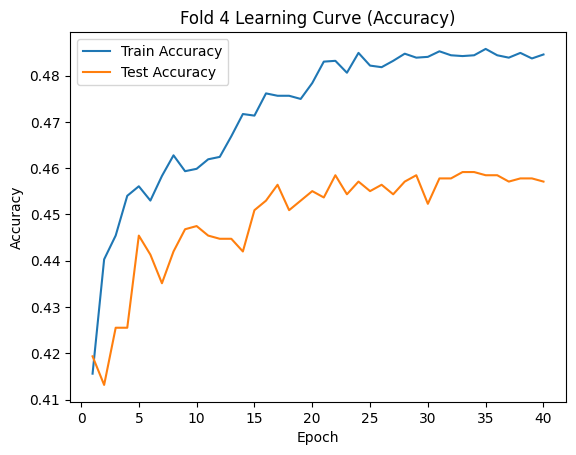

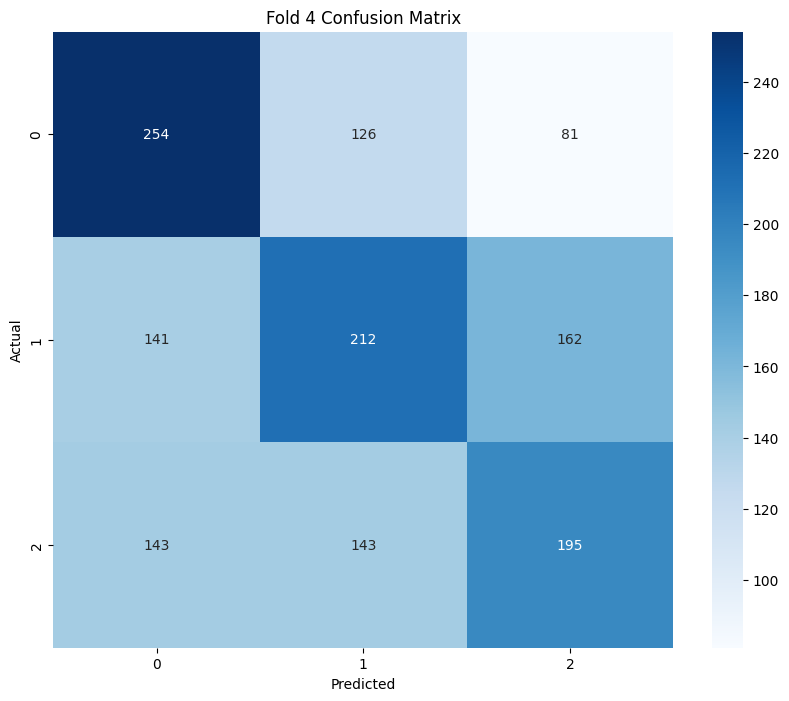


Fold 5/5 진행 중...
Epoch 1/40 - Train Loss: 1.0675, Train Acc: 0.4122, Test Acc: 0.4386
Epoch 2/40 - Train Loss: 1.0502, Train Acc: 0.4334, Test Acc: 0.4324
Epoch 3/40 - Train Loss: 1.0452, Train Acc: 0.4461, Test Acc: 0.4276
Epoch 4/40 - Train Loss: 1.0448, Train Acc: 0.4432, Test Acc: 0.4564
Epoch 5/40 - Train Loss: 1.0434, Train Acc: 0.4479, Test Acc: 0.4427
Epoch 6/40 - Train Loss: 1.0402, Train Acc: 0.4530, Test Acc: 0.4626
Epoch 7/40 - Train Loss: 1.0393, Train Acc: 0.4504, Test Acc: 0.4468
Epoch 8/40 - Train Loss: 1.0376, Train Acc: 0.4612, Test Acc: 0.4674
Epoch 9/40 - Train Loss: 1.0367, Train Acc: 0.4659, Test Acc: 0.4461
Epoch 10/40 - Train Loss: 1.0348, Train Acc: 0.4631, Test Acc: 0.4550
Epoch 11/40 - Train Loss: 1.0337, Train Acc: 0.4664, Test Acc: 0.4530
Epoch 12/40 - Train Loss: 1.0331, Train Acc: 0.4707, Test Acc: 0.4660
Epoch 13/40 - Train Loss: 1.0326, Train Acc: 0.4671, Test Acc: 0.4640
Epoch 14/40 - Train Loss: 1.0329, Train Acc: 0.4654, Test Acc: 0.4681
Epoch 15/40

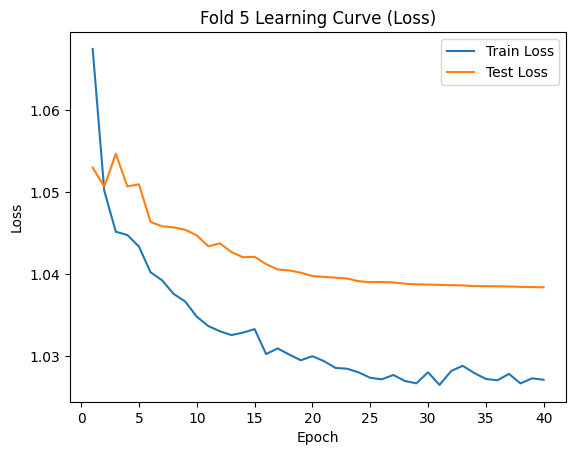

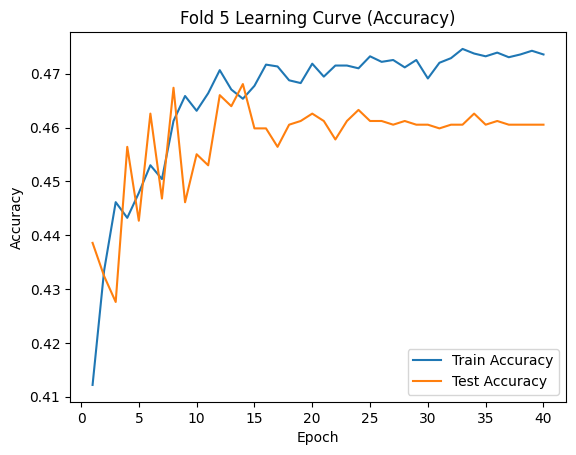

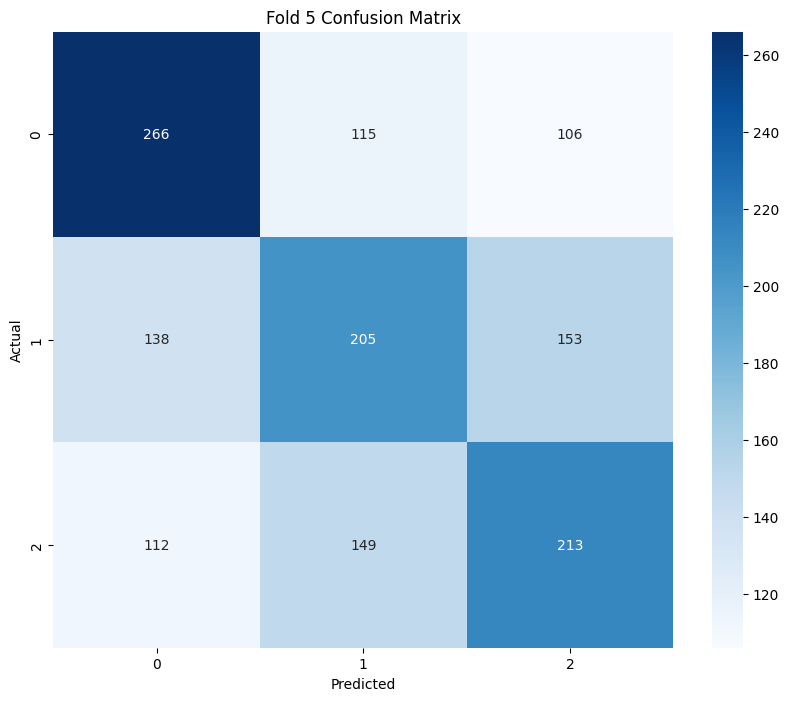

Checkpoint saved at /home/Minju/Perceiver/shared_layer_model/image_checkpoint_1_epoch_40.pth.tar

=== K-Fold 결과 요약 ===
Fold 1 - Test Accuracy: 0.4890
              precision    recall  f1-score      support
0              0.532417  0.548583  0.540379   494.000000
1              0.430108  0.431965  0.431034   463.000000
2              0.500000  0.483034  0.491371   501.000000
accuracy       0.489026  0.489026  0.489026     0.489026
macro avg      0.487508  0.487861  0.487595  1458.000000
weighted avg   0.488788  0.489026  0.488815  1458.000000
Fold 2 - Test Accuracy: 0.4890
              precision    recall  f1-score     support
0              0.495413  0.574468  0.532020   470.00000
1              0.407484  0.393574  0.400409   498.00000
2              0.462963  0.408163  0.433839   490.00000
accuracy       0.456790  0.456790  0.456790     0.45679
macro avg      0.455287  0.458735  0.455423  1458.00000
weighted avg   0.454474  0.456790  0.454070  1458.00000
Fold 3 - Test Accuracy: 0.48

In [ ]:
for i in range(0, len(target_classes), GROUP_CLASS):  
    print(f"실험 {i//GROUP_CLASS + 1} 시작")
    selected_classes = target_classes[i:i+GROUP_CLASS]
    print(f"Selected Feature: {selected_classes}")

    filtered_dataset = ImageDataset(root_dir=data_dir, 
                                    transform=transform, 
                                    crop_size=CROP_SIZE, 
                                    patch_size=PATCH_SIZE,
                                    selected_classes=selected_classes)
    all_labels = [label_idx for (_, label_idx) in filtered_dataset.data]

    # 1) 유니크 라벨과 개수
    unique_label_ids = np.unique(all_labels)
    print("Unique numeric labels:", unique_label_ids)
    print("Number of unique numeric labels:", len(unique_label_ids))

    # 2) 라벨별 개수 (분포)
    label_counts = Counter(all_labels)
    print("Label distribution (index: count):", label_counts)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    NUM_CLASSES = len(label_counts)

    train_kfold(i+1, filtered_dataset, NUM_CLASSES, device, model_path, loader_path)
    
    # train_ratio = 0.8
    # train_size = int(len(filtered_dataset) * train_ratio)
    # valid_size = len(filtered_dataset) - train_size


    # train_dataset, valid_dataset = random_split(filtered_dataset, [train_size, valid_size])
    # train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    #                           num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=g)
    # valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
    #                           num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=g)

    # print(f"train: {train_size}, valid: {valid_size}")
    
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # NUM_CLASSES = len(filtered_dataset.label_encoder.classes_)
    # model = Perceiver(input_dim=(PATCH_SIZE**2) * 3 + 2,
    #                     latent_dim=64, 
    #                     latent_size=64, 
    #                     num_classes=NUM_CLASSES, 
    #                     num_blocks=4, 
    #                     self_attn_layers_per_block=10).to(device)
    # criterion = nn.CrossEntropyLoss()
    # optimizer = optim.AdamW(model.parameters(), lr=LR)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Learning rate decay 추가

    # start = time.perf_counter()
    # train_losses, val_accuracies, best_model = train_model(
    #     model, train_loader, valid_loader,
    #     criterion, optimizer, EPOCHS,
    #     device=device,
    #     scheduler=scheduler  
    # )
    
    # final_acc = evaluate_model(best_model, valid_loader, device=device, log_results=True)
    # end = time.perf_counter()
    # hour = (end-start) // 3600
    # min = ((end-start) % 3600) // 60
    # sec = int((end-start) % 60)
    # print(f"Train time: {hour}h {min}m {sec}s")
    # print(f"Final Validation Accuracy: {final_acc:.2f}%")
    # print("----------------------------------------------------------")
    
    # torch.save(best_model, f'{output_path}/image_model_{i//GROUP_CLASS+1}.pkl')

    # val_loader_save_path = f"{loader_path}/image_val_loader_{i//GROUP_CLASS+1}.pkl"
    # with open(val_loader_save_path, 'wb') as f:
    #     pickle.dump(valid_dataset, f)